In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fake-news-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F890123%2F1510812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241004%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241004T093840Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D40c303fd41db1a0e666a739e5912fd5b846bcae63227301d8deecc237876617919ea6292e9d09d739c78983d45c96048cf69674e2946dacdafb2e66da4df56ec42f565a047a1b4ff11bc65c1107b7423114e45dbe14ad99be80bb0f605368021a65db8627739119d84d01209fb5e5387819189af0095a0da123f6057e007fc19d86aafebc6b600b4bec992b66619cd458ef9dafd977bc301dd1bc10b0b96830fc31508080c6313d828909613d57fe1bc6f67ab3434eea518a101b43bf6bca020e5103ec68a45b21c55c0f01d4279eb151743e62bb83355ecba874fd01ef46a14a76553b83024ed573b753189dd62881e12e5ee80dd492ce52bd602ce7d3fcf22'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 42975911 bytes downloaded
Downloaded and uncompressed: fake-news-detection
Data source import complete.


# Fake News Detection

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string

## Importing Dataset

In [3]:
df_fake = pd.read_csv("../input/fake-news-detection/Fake.csv")
df_true = pd.read_csv("../input/fake-news-detection/True.csv")

Accuracy: 99.11%
Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      4668
        True       0.99      0.99      0.99      4308

    accuracy                           0.99      8976
   macro avg       0.99      0.99      0.99      8976
weighted avg       0.99      0.99      0.99      8976



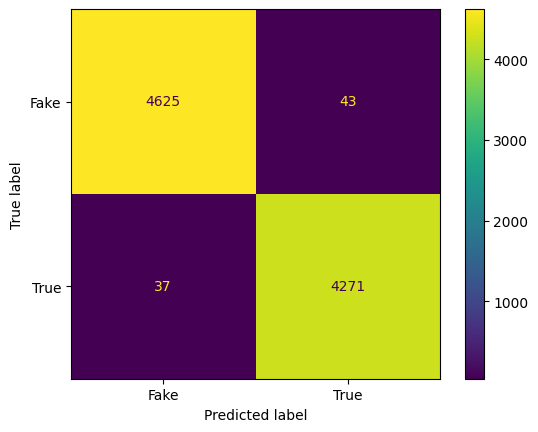

Confusion Matrix:
[[4625   43]
 [  37 4271]]


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


# Add a label column
df_fake['label'] = 0  # Fake news
df_true['label'] = 1  # True news

# Combine the datasets
df = pd.concat([df_fake, df_true], axis=0)

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Drop unnecessary columns
df = df.drop(['date'], axis=1)

# Data Preprocessing
# We will use 'title', 'text', and 'subject' columns for feature extraction
X = df['title'] + " " + df['text'] + " " + df['subject']  # Concatenate features
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression Model
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot()

# Save confusion matrix plot
plt.savefig('confusion_matrix.png')

# Show Confusion Matrix
plt.show()

# Accuracy plot
def plot_accuracy(history):
    plt.figure(figsize=(8,6))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='test accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

# Display confusion matrix and accuracy score
print(f"Confusion Matrix:\n{cm}")


In [5]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## Inserting a column "class" as target feature

In [7]:
df_fake["class"] = 0
df_true["class"] = 1

In [8]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [9]:
# Removing last 10 rows for manual testing
df_fake_manual_testing = df_fake.tail(10)
for i in range(23480,23470,-1):
    df_fake.drop([i], axis = 0, inplace = True)


df_true_manual_testing = df_true.tail(10)
for i in range(21416,21406,-1):
    df_true.drop([i], axis = 0, inplace = True)

In [10]:
df_fake.shape, df_true.shape

((23471, 5), (21407, 5))

In [11]:
df_fake_manual_testing["class"] = 0
df_true_manual_testing["class"] = 1

<ipython-input-11-3aaf8ec2aad1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake_manual_testing["class"] = 0
<ipython-input-11-3aaf8ec2aad1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_manual_testing["class"] = 1


In [12]:
df_fake_manual_testing.head(10)

,title,text,subject,date,class
23471,Seven Iranians freed in the prisoner swap have...,"21st Century Wire says This week, the historic...",Middle-east,"January 20, 2016",0
23472,#Hashtag Hell & The Fake Left,By Dady Chery and Gilbert MercierAll writers ...,Middle-east,"January 19, 2016",0
23473,Astroturfing: Journalist Reveals Brainwashing ...,Vic Bishop Waking TimesOur reality is carefull...,Middle-east,"January 19, 2016",0
23474,The New American Century: An Era of Fraud,Paul Craig RobertsIn the last years of the 20t...,Middle-east,"January 19, 2016",0
23475,Hillary Clinton: ‘Israel First’ (and no peace ...,Robert Fantina CounterpunchAlthough the United...,Middle-east,"January 18, 2016",0
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


In [13]:
df_true_manual_testing.head(10)

,title,text,subject,date,class
21407,"Mata Pires, owner of embattled Brazil builder ...","SAO PAULO (Reuters) - Cesar Mata Pires, the ow...",worldnews,"August 22, 2017",1
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21409,"U.S., North Korea clash at U.N. arms forum on ...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017",1
21410,Headless torso could belong to submarine journ...,COPENHAGEN (Reuters) - Danish police said on T...,worldnews,"August 22, 2017",1
21411,North Korea shipments to Syria chemical arms a...,UNITED NATIONS (Reuters) - Two North Korean sh...,worldnews,"August 21, 2017",1
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [14]:
df_manual_testing = pd.concat([df_fake_manual_testing,df_true_manual_testing], axis = 0)
df_manual_testing.to_csv("manual_testing.csv")

## Merging True and Fake Dataframes

In [15]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [16]:
df_merge.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

## Removing columns which are not required

In [17]:
df = df_merge.drop(["title", "subject","date"], axis = 1)

In [18]:
df.isnull().sum()

,0
text,0
class,0


## Random Shuffling the dataframe

In [19]:
df = df.sample(frac = 1)

In [20]:
df.head()

,text,class
15110,Rep. Kevin McCarthy (R-CA) has dropped out of ...,0
21465,Occupy Wall Street 2011:The fun is over for a ...,0
971,If today on Fox News was any indication at all...,0
13428,Last night the press swooned over Bitter Mooch...,0
13166,Hillary Clinton delivered a disgusting speech ...,0


In [21]:
df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)

In [22]:
df.columns

Index(['text', 'class'], dtype='object')

In [23]:
df.head()

,text,class
0,Rep. Kevin McCarthy (R-CA) has dropped out of ...,0
1,Occupy Wall Street 2011:The fun is over for a ...,0
2,If today on Fox News was any indication at all...,0
3,Last night the press swooned over Bitter Mooch...,0
4,Hillary Clinton delivered a disgusting speech ...,0


## Creating a function to process the texts

In [24]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [25]:
df["text"] = df["text"].apply(wordopt)

## Defining dependent and independent variables

In [26]:
x = df["text"]
y = df["class"]

## Splitting Training and Testing

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

## Convert text to vectors

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)

LogisticRegression()

In [30]:
pred_lr=LR.predict(xv_test)

In [31]:
LR.score(xv_test, y_test)

0.985650623885918

In [32]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5859
           1       0.98      0.99      0.99      5361

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220



## Decision Tree Classification

In [33]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [34]:
pred_dt = DT.predict(xv_test)

In [35]:
DT.score(xv_test, y_test)

0.9936720142602495

In [36]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5859
           1       0.99      0.99      0.99      5361

    accuracy                           0.99     11220
   macro avg       0.99      0.99      0.99     11220
weighted avg       0.99      0.99      0.99     11220



## Gradient Boosting Classifier

In [42]:
# Ensure train_test_split is consistent
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (35902,)
y_train shape: (35902,)


In [46]:
def output_lable(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    pred_DT = DT.predict(new_xv_test)
    pred_GBC = GBC.predict(new_xv_test)
    pred_RFC = RFC.predict(new_xv_test)

    return print("\n\nLR Prediction: {} \nDT Prediction: {} \nGBC Prediction: {} \nRFC Prediction: {}".format(output_lable(pred_LR[0]),                                                                                                       output_lable(pred_DT[0]),
                                                                                                              output_lable(pred_GBC[0]),
                                                                                                              output_lable(pred_RFC[0])))